In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health-counseling-conversations-k/combined_dataset.json
/kaggle/input/mental-health-counseling-conversations-k/archive/counsel_chat2.csv
/kaggle/input/mental-health-counseling-conversations-k/archive/counselchat-data.csv
/kaggle/input/mental-health-counseling-conversations-k/archive/Dataset.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [4]:
df = pd.read_csv('/kaggle/input/mental-health-counseling-conversations-k/archive/counselchat-data.csv')
df.head()

,questionID,questionTitle,questionText,questionUrl,topics,therapistName,therapistUrl,answerText,upvotes
0,5566fab2a64752d71ec3ca69,Escalating disagreements between mother and wife,My wife and mother are having tense disagreeme...,https://counselchat.com/questions/escalating-d...,Family Conflict,"Kristi King-Morgan, LMSW",https://counselchat.com/therapists/kristi-king...,<p>What you are describing is something psycho...,0
1,5566f94fa64752d71ec3ca64,I'm addicted to smoking. How can I stop?,"I'm planning to have baby, so I have to quit s...",https://counselchat.com/questions/i-m-addicted...,"Substance Abuse,Addiction",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>Hi. Good for you in planning ahead to do wh...,0
2,5567d26887a1cc0c3f3d8f46,Keeping secrets from my family,"I have secrets in my mind, and I don't know wh...",https://counselchat.com/questions/keeping-secr...,Family Conflict,Jeevna Bajaj,https://counselchat.com/therapists/jeevna-bajaj,<p>It sounds like keeping the secrets has beco...,0
3,556bed15c969ba5861709df5,The Underlying Causes of Being Possessive,I am extremely possessive in my relationships ...,https://counselchat.com/questions/the-underlyi...,"Behavioral Change,Social Relationships",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>Hi there. It's great you are able to realiz...,0
4,556ba115c969ba5861709de6,Can I control anxiety without medication?,I had a head injury a few years ago and my min...,https://counselchat.com/questions/can-i-contro...,Anxiety,Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>You didn't say what or how many medications...,0


In [5]:
df.columns

Index(['questionID', 'questionTitle', 'questionText', 'questionUrl', 'topics',
       'therapistName', 'therapistUrl', 'answerText', 'upvotes'],
      dtype='object')

In [6]:
print(df.shape)          # rows, columns

(1482, 9)


In [7]:
df.info()                # nulls, types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   questionID     1482 non-null   object
 1   questionTitle  1480 non-null   object
 2   questionText   1383 non-null   object
 3   questionUrl    1482 non-null   object
 4   topics         1472 non-null   object
 5   therapistName  1482 non-null   object
 6   therapistUrl   1482 non-null   object
 7   answerText     1482 non-null   object
 8   upvotes        1482 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 104.3+ KB


In [8]:
df.describe(include='object')  # text-based stats

,questionID,questionTitle,questionText,questionUrl,topics,therapistName,therapistUrl,answerText
count,1482,1480,1383,1482,1472,1482,1482,1482
unique,781,774,718,780,288,159,160,1478
top,579e400d188cd61c1684e835,Is it normal to go into therapy feeling nervous?,I've gone to a couple therapy sessions so far ...,https://counselchat.com/questions/is-it-normal...,Relationships,"Sherry Katz, LCSW",https://counselchat.com/therapists/sherry-katz...,<p><br></p>
freq,22,22,22,22,116,275,275,5


In [9]:
df = df[['questionText', 'topics']].dropna()
df['main_topic'] = df['topics'].apply(lambda x: x.split(',')[0])
df = df[['questionText', 'main_topic']]
df.head()

,questionText,main_topic
0,My wife and mother are having tense disagreeme...,Family Conflict
1,"I'm planning to have baby, so I have to quit s...",Substance Abuse
2,"I have secrets in my mind, and I don't know wh...",Family Conflict
3,I am extremely possessive in my relationships ...,Behavioral Change
4,I had a head injury a few years ago and my min...,Anxiety


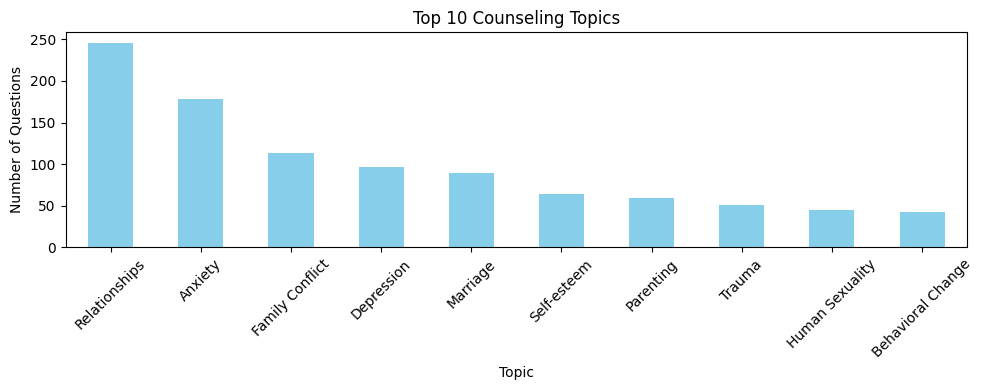

In [10]:
plt.figure(figsize=(10,4))
df['main_topic'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Counseling Topics')
plt.xlabel('Topic'); plt.ylabel('Number of Questions'); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

In [11]:
X = df['questionText']
y = df['main_topic']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [14]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [15]:
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

                Addiction       1.00      0.33      0.50         3
         Anger Management       1.00      0.20      0.33         5
                  Anxiety       0.67      0.85      0.75        34
        Behavioral Change       1.00      0.10      0.18        10
   Children & Adolescents       0.00      0.00      0.00         1
 Counseling Fundamentals        1.00      0.90      0.95        10
               Depression       0.73      0.47      0.57        17
                Diagnosis       0.00      0.00      0.00         4
        Domestic Violence       0.00      0.00      0.00         2
         Eating Disorders       0.00      0.00      0.00         1
          Family Conflict       0.67      0.38      0.49        26
           Grief and Loss       0.00      0.00      0.00         2
          Human Sexuality       1.00      0.50      0.67         6
                 Intimacy       1.00      0.25      0.40     